# Training Linear Models

## Imports and Parameters

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path

In [2]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

In [3]:
# Reproducibility
np.random.seed(42)

# Closed form solution for linear regression

Text(0, 0.5, '$y$')

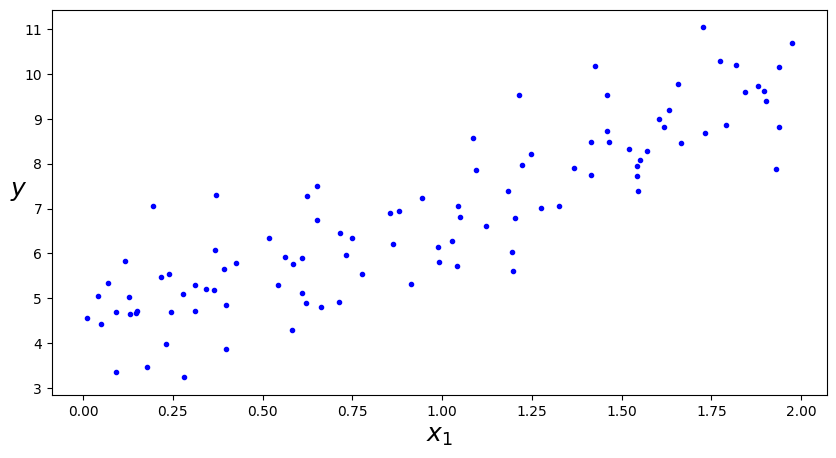

In [4]:
# Generate some data to test the equation

m = 100 # number of instances
X = 2 * np.random.rand(m, 1)
y = 4 + 3 * X + np.random.randn(m, 1)

# Plot the data
plt.figure(figsize=(10, 5))
plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)

In [5]:
# Computing the best theta using the Normal Equation

from sklearn.preprocessing import add_dummy_feature
X_b = add_dummy_feature(X) 		# add x0 = 1 to each instance
theta_best = np.linalg.inv(X_b.T @ X_b) @ X_b.T @ y

In [6]:
theta_best

array([[4.21509616],
       [2.77011339]])

In [7]:
# Making predictions using theta_best
X_new = np.array([[0], [2]])	# two instances at the extremes
X_new_b = add_dummy_feature(X_new)		# add x0 = 1 to each instance
y_predict = X_new_b @ theta_best

In [8]:
y_predict

array([[4.21509616],
       [9.75532293]])

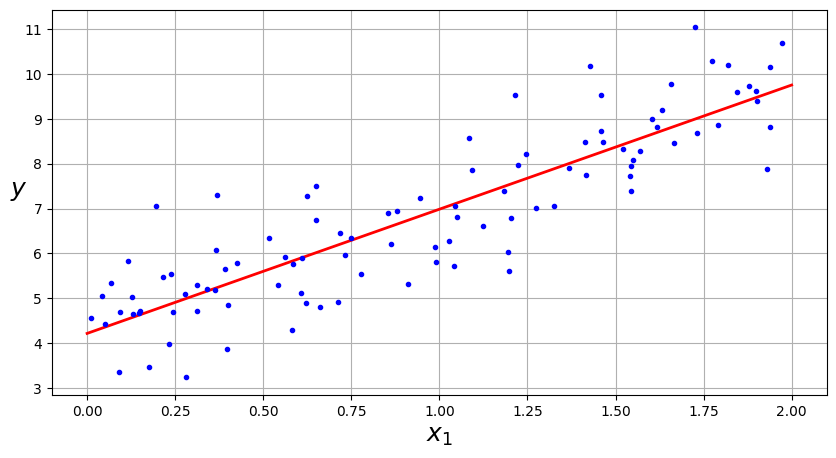

In [9]:
# Plot the model
plt.figure(figsize=(10, 5))
plt.plot(X_new, y_predict, "r-", linewidth=2, label="Predictions")
plt.plot(X, y, "b.", label="Data")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.grid()

In [10]:
# Using Scikit-Learn
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X, y)
print(f"Using Scikit-Learn:")
print(f"Intercept: {lin_reg.intercept_.item():.3f}; Slope:{ lin_reg.coef_.item():.3f}")
preds = lin_reg.predict(X_new)
print(f"Points (x, y): (0, {preds[0].item():.3f}); (2, {preds[1].item():.3f})")
print(f"Using Normal Equation:")
print(f"Intercept: {theta_best[0].item():.3f}; Slope:{ theta_best[1].item():.3f}")
print(f"Points (x, y): (0, {y_predict[0].item():.3f}); (2, {y_predict[1].item():.3f})")

Using Scikit-Learn:
Intercept: 4.215; Slope:2.770
Points (x, y): (0, 4.215); (2, 9.755)
Using Normal Equation:
Intercept: 4.215; Slope:2.770
Points (x, y): (0, 4.215); (2, 9.755)


# Gradient descent

In [15]:
# A simple implementation of gradient descent

eta = 0.1 		# learning rate
epochs = 10000	# number of iterations
m = len(X_b) 	# number of instances

# Initialize theta at a random value
np.random.seed(42)
theta = np.random.randn(2, 1)

for epoch in range(epochs):
	gradients = 2/m * X_b.T @ (X_b @ theta - y)
	theta = theta -eta * gradients

print(f"Using Gradient Descent:")
print(f"Values for the generated data: ")
print("Intercept: 4; Slope: 3")
print(f"Intercept: {theta[0].item():.3f}; Slope:{ theta[1].item():.3f}")

Using Gradient Descent:
Values for the generated data: 
Intercept: 4; Slope: 3
Intercept: 4.215; Slope:2.770
